## Imports

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from keras.models import Model
import boto3
from time import time
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod

## Classes to handle dataset images

In [28]:
class DatasetHandler(ABC):
    def __init__(self,
                obstacle_dataset,
                no_obstacle_dataset,
                img_width=200,
                img_height=200,
                batch_size=32,
                rand_images=True,
                num_rand_images=10):
        
        self.obstacle_dataset = obstacle_dataset
        self.no_obstacle_dataset = no_obstacle_dataset
        self.dataset = '/'.join(self.obstacle_dataset.split('/')[:-1])
        self.img_width = img_width
        self.img_height = img_height
        self.obstacle_images = []
        self.no_obstacle_images = []
        self._update_image_lists = True
        self.rand_images = rand_images
        
        if rand_images:
            self.batch_size = min(batch_size, num_rand_images*2)
        else:
            self.batch_size = batch_size
            
        if rand_images:
            self.num_rand_images = num_rand_images
            self.num_obstacles = num_rand_images
            self.num_no_obstacles = num_rand_images
            self.num_images = num_rand_images*2
        else:
            # Will be determined while reading all images from dataset
            self.num_obstacles = 0
            self.num_no_obstacles = 0
            self.num_images = 0
            
        if rand_images:
            self.obstacle_image_names = self._get_random_dataset_image_names(self.obstacle_dataset)
            self.no_obstacle_image_names = self._get_random_dataset_image_names(self.no_obstacle_dataset)
        else:
            (self.obstacle_image_names,
            self.num_obstacles) = self._get_all_dataset_image_names(self.obstacle_dataset)
            (self.no_obstacle_image_names,
            self.num_no_obstacles) = self._get_all_dataset_image_names(self.no_obstacle_dataset)
            
    @abstractmethod
    def _get_random_dataset_image_names(self, dataset):
        pass
    
    @abstractmethod
    def _get_all_dataset_image_names(self, dataset):
        pass
    
    @abstractmethod
    def _get_image(self, imname):
        pass
    
    def _preprocess_image(self, im):
        w = im.shape[1]
        im1 = im[:,:w//2]
        im2 = im[:,w//2:]
        sub = cv2.subtract(im1, im2)
        sub = sub.reshape(sub.shape[0], sub.shape[1], 1)
        arr = keras.preprocessing.image.smart_resize(sub,
                                                     (self.img_height, self.img_width),
                                                     interpolation='bilinear')
        arr /= 255.0
        return arr
    
    def image_generator(self):
        inputs = []
        outputs = [0]*self.num_no_obstacles + [1]*self.num_obstacles

        for image_name in tqdm(self.no_obstacle_image_names):
            im = self._get_image(image_name)
            if self._update_image_lists:
                self.no_obstacle_images.append(im)
            im = self._preprocess_image(im)
            inputs.append(im)

        for image_name in tqdm(self.obstacle_image_names):
            im = self._get_image(image_name)
            if self._update_image_lists:
                self.obstacle_images.append(im)
            im = self._preprocess_image(im)
            inputs.append(im)
            
        self._update_image_lists = False

        for i in range(0, self.num_images, self.batch_size):
            x = np.array(inputs[i:i+self.batch_size])
            y = np.array(outputs[i:i+self.batch_size])
            yield(x, y)
            
    @abstractmethod
    def get_metrics(self, model):
        pass
    
    @abstractmethod
    def get_predictions(self, model):
        pass

In [29]:
class CloudDatasetHandler(DatasetHandler):
    
    def _get_random_dataset_image_names(self, dataset):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        image_names = []

        paginator = client.get_paginator('list_objects')
        page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

        for page in page_iterator:
            for image_name in page['Contents']:
                if image_name['Key'].split('.')[-1] == 'jpg':
                    image_names.append(image_name['Key'])

        image_names = np.array(image_names)
        np.random.shuffle(image_names)
        image_names = image_names[:self.num_rand_images]

        return list(image_names)

    def _get_all_dataset_image_names(self, dataset):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        image_names = []
        num_images = 0

        paginator = client.get_paginator('list_objects')
        page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

        for page in page_iterator:
            for image_name in page['Contents']:
                if image_name['Key'].split('.')[-1] == 'jpg':
                    image_names.append(image_name['Key'])
                    num_images += 1

        return image_names, num_images
            
    def _get_image(self, imname):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        key = imname
        outfile = io.BytesIO()
        client.download_fileobj(bucket, key, outfile)
        outfile.seek(0)
        im = plt.imread(outfile, format='jpg')
        
        return im
    
    def get_metrics(self, model):
        return model.evaluate_generator(self.image_generator(), verbose=1)
    
    def get_predictions(self,model):
        return model.predict_generator(self.image_generator(), verbose=1)

In [30]:
class LocalDatasetHandler(DatasetHandler):
        
    def _get_random_dataset_image_names(self, dataset):
        image_names = os.listdir(dataset)
        image_paths = [os.path.join(dataset, image_name) for image_name in image_names]
        image_paths = np.array(image_paths)
        np.random.shuffle(image_paths)
        image_paths = image_paths[:self.num_rand_images]

        return list(image_paths)

    def _get_all_dataset_image_names(self, dataset):
        image_names = os.listdir(dataset)
        image_paths = [os.path.join(dataset, image_name) for image_name in image_names]
        
        return image_paths, len(image_paths)
            
    def _get_image(self, imname):
        imrgb = cv2.imread(imname)
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2GRAY) 
        
        return im
    
    def get_metrics(self, model):
        if self.rand_images:
            return model.evaluate_generator(self.image_generator(), verbose=1)
        else:
            datagen = ImageDataGenerator(rescale=1./255)

            val_generator = datagen.flow_from_directory(
                self.dataset,
                target_size=(self.img_width, self.img_height),
                color_mode='grayscale',
                batch_size=self.batch_size,
                shuffle=False,
                class_mode='binary'
            )
            
            return model.evaluate_generator(val_generator, verbose=1)
        
    def get_predictions(self, model):
        if self.rand_images:
            return model.predict_generator(self.image_generator(), verbose=1)
        else:
            datagen = ImageDataGenerator(rescale=1./255)

            val_generator = datagen.flow_from_directory(
                self.dataset,
                target_size=(self.img_width, self.img_height),
                color_mode='grayscale',
                batch_size=self.batch_size,
                shuffle=False,
                class_mode='binary'
            )
            
            return model.predict_generator(val_generator, verbose=1)

## Function to display Confusion Matrix

In [31]:
def plot_cm(labels, predictions, p=0.5, not_decided=None):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    tot_predicts = sum(sum(x) for x in cm)

    print(f'No Obstacles Detected (True Negatives): {cm[0][0]} ({(cm[0][0]/tot_predicts)*100:.2f}%)')
    print(f'No Obstacles Incorrectly Detected (False Positives): {cm[0][1]} ({(cm[0][1]/tot_predicts)*100:.2f}%)')
    print(f'Obstacles Missed (False Negatives): {cm[1][0]} ({(cm[1][0]/tot_predicts)*100:.2f}%)')
    print(f'Obstacles Detected (True Positives): {cm[1][1]} ({(cm[1][1]/tot_predicts)*100:.2f}%)')
    if not_decided:
        print(f'Not Decided: {not_decided} ({(not_decided/tot_predicts)*100:.2f}%)')
    print(f'Total Obstacles: {tot_predicts}')
        

## Function to consider decision margins for displating confusion matrix

In [32]:
def consider_margins(labels, predictions, lower_margin, upper_maring, threshold):
    no_obs_preds = predictions[:handler.num_no_obstacles]
    no_obs_margin_preds = [0.0 if lower_margin < p < upper_margin else p for p in no_obs_preds]
    obs_preds = predictions[handler.num_no_obstacles:]
    obs_margin_preds = [1.0 if lower_margin < p < upper_margin else p for p in obs_preds]
    margin_preds = no_obs_margin_preds + obs_margin_preds
    margin_preds = np.array(margin_preds, dtype=float)
    
    # Calculate no. of predictions returned "not decided"
    no_obs_orig_zeros = [p for p in no_obs_preds if p == 0.0]
    no_obs_zeros = [p for p in margin_preds[:handler.num_no_obstacles] if p == 0.0]
    no_obs_not_decided = len(no_obs_zeros) - len(no_obs_orig_zeros)
    obs_orig_ones = [p for p in obs_preds if p == 1.0]
    obs_ones = [p for p in margin_preds[handler.num_no_obstacles:] if p == 1.0]
    obs_not_decided = len(obs_ones) - len(obs_orig_ones)
    not_decided = no_obs_not_decided + obs_not_decided

    plot_cm(labels, margin_preds, p=threshold, not_decided=not_decided)

## Main

In [33]:
# Set these variables per actual environment
model_path = '/home/drevital/cs_video_processor/models/suzuyo'
cloud_dataset = False
obstacle_dataset = '/home/drevital/obstacles_classification_datasets/suzuyo/eval/obstacle'
#obstacle_dataset = 'suzuyo/eval_pairs/obstacle'
no_obstacle_dataset = '/home/drevital/obstacles_classification_datasets/suzuyo/eval/no_obstacle'
#no_obstacle_dataset = 'suzuyo/eval_pairs/no_obstacle'
rand_images = False
num_rand_images = 10
display_negatives = False

#
model = tf.keras.models.load_model(model_path)
dataset_handlers = [LocalDatasetHandler, CloudDatasetHandler]
handler = dataset_handlers[cloud_dataset](obstacle_dataset,
                                         no_obstacle_dataset,
                                         rand_images=rand_images,
                                         num_rand_images=num_rand_images)

## Evaluate Model

In [34]:
metrics = handler.get_metrics(model)

for name, value in zip(model.metrics_names, metrics):
  print(name, ': ', value)
print()

Found 3501 images belonging to 2 classes.
110/110 [==============================] - 12s 105ms/step - loss: 0.4332 - auc: 0.9747 - recall: 0.9244 - specifity: 0.9480
loss :  0.4332197308540344
auc :  0.9747198820114136
recall :  0.9243649244308472
specifity :  0.9479932188987732



## Predict with the model and print prediction charts

Found 3501 images belonging to 2 classes.
110/110 [==============================] - 15s 131ms/step
No Obstacles Detected (True Negatives): 1634 (46.67%)
No Obstacles Incorrectly Detected (False Positives): 135 (3.86%)
Obstacles Missed (False Negatives): 131 (3.74%)
Obstacles Detected (True Positives): 1601 (45.73%)
Total Obstacles: 3501
No Obstacles Detected (True Negatives): 1656 (47.30%)
No Obstacles Incorrectly Detected (False Positives): 113 (3.23%)
Obstacles Missed (False Negatives): 112 (3.20%)
Obstacles Detected (True Positives): 1620 (46.27%)
Not Decided: 87 (2.49%)
Total Obstacles: 3501


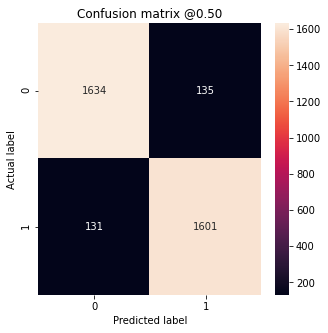

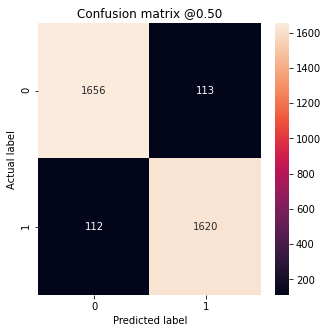

In [35]:
labels = np.array([0]*(handler.num_no_obstacles) + [1]*(handler.num_obstacles))
predictions = handler.get_predictions(model)
threshold = 0.5
decision_margin = 0.25
upper_margin = threshold + decision_margin * (1.00 - threshold)
lower_margin = threshold * (1.00 - decision_margin)
plot_cm(labels, predictions) # Default: threshold = 0.5
consider_margins(labels, predictions, lower_margin, upper_margin, threshold)

## Display False Negatives

In [36]:
if display_negatives:
    false_negatives = [im for i, im in enumerate(handler.obstacle_images) if predictions[i] <= 0.5]

    if 500 > len(false_negatives) > 1:
        num_images = len(false_negatives)
        _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

        for i, im in enumerate(false_negatives):
            axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)
    elif false_negatives:
        plt.imshow(false_negatives[0], cmap='gray', vmin=0, vmax=255)
        plt.show()     

## Display False Positives

In [37]:
if display_negatives:
    false_positives = [im for i, im in enumerate(handler.no_obstacle_images) if predictions[i+handler.num_obstacles] > 0.5]

    if 500 > len(false_positives) > 1:
        num_images = len(false_positives)
        _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

        for i, im in enumerate(false_positives):
            axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)
    elif false_positives:
        plt.imshow(false_positives[0], cmap='gray', vmin=0, vmax=255)
        plt.show()    

## Find Optimal Threshold

In [38]:
true_values = [0]*handler.num_no_obstacles + [1]*handler.num_obstacles 
fpr, tpr, thresholds = roc_curve(true_values, predictions)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
optimal_threshold = thresholds[ix]
print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.5963765978813171


## Use Optimal Threshold

No Obstacles Detected (True Negatives): 1655 (47.27%)
No Obstacles Incorrectly Detected (False Positives): 114 (3.26%)
Obstacles Missed (False Negatives): 141 (4.03%)
Obstacles Detected (True Positives): 1591 (45.44%)
Total Obstacles: 3501


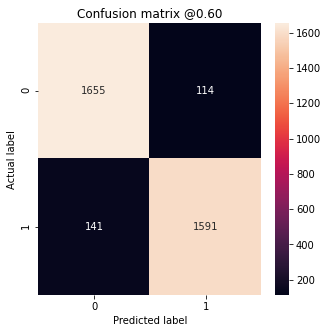

In [39]:
plot_cm(labels, predictions, p=optimal_threshold) 

## Show decision margin for optimal_threshold

In [40]:
decision_margin = 0.25
upper_margin = optimal_threshold + decision_margin * (1.00 - optimal_threshold)
lower_margin = optimal_threshold * (1.00 - decision_margin)

In [41]:
optimal_threshold, lower_margin, upper_margin

(0.5963766, 0.44728244841098785, 0.6972824484109879)

## Show results considering optimal_threshold + decision margin

No Obstacles Detected (True Negatives): 1665 (47.56%)
No Obstacles Incorrectly Detected (False Positives): 104 (2.97%)
Obstacles Missed (False Negatives): 123 (3.51%)
Obstacles Detected (True Positives): 1609 (45.96%)
Not Decided: 75 (2.14%)
Total Obstacles: 3501


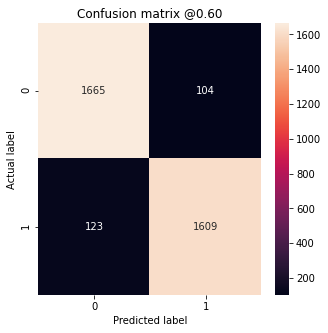

In [42]:
consider_margins(labels, predictions, lower_margin, upper_margin, optimal_threshold)

No Obstacles Detected (True Negatives): 1665 (47.56%)
No Obstacles Incorrectly Detected (False Positives): 104 (2.97%)
Obstacles Missed (False Negatives): 43 (1.23%)
Obstacles Detected (True Positives): 1689 (48.24%)
Not Decided: 469 (13.40%)
Total Obstacles: 3501


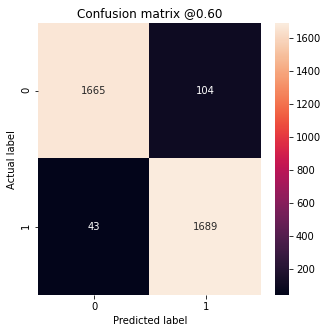

In [43]:
consider_margins(labels, predictions, 0.10, 0.80, optimal_threshold)